

### **Training Convolutional Neural Networks (CNNs)**


In [ ]:
import torch
from torch import nn
import torchvision
import torchvision.transforms as transforms
import torchvision.transforms.v2 as v2
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.tensorboard import SummaryWriter

#### Define the Dataset, Dataloader, Transforms, Download FASHION MNIST



In [ ]:
mean = [0.485]
std = [0.229]

# transform pipelines for train and test datasets
transforms_train = v2.Compose([
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    #v2.RandomResizedCrop(size=(10, 10), antialias=True),
    v2.Normalize(mean=mean, std=std),
])
transforms_test = v2.Compose(
    [
        v2.ToImage(),
        v2.ToDtype(torch.float32, scale=True),
        v2.Normalize(mean=mean, std=std),
    ]
)

batch_size = 128

trainset = torchvision.datasets.FashionMNIST(root="./Data", train=True, transform=transforms_train, download=True)
testset = torchvision.datasets.FashionMNIST(root="./Data", train=False, transform=transforms_test, download=True)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False)

100%|██████████| 26421880/26421880 [00:01<00:00, 16305834.42it/s]


Extracting ./Data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./Data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 295523.71it/s]


Extracting ./Data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./Data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:00<00:00, 5345027.26it/s]


Extracting ./Data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./Data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 12686414.21it/s]


Extracting ./Data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./Data/FashionMNIST/raw



torch.Size([1, 1, 1])


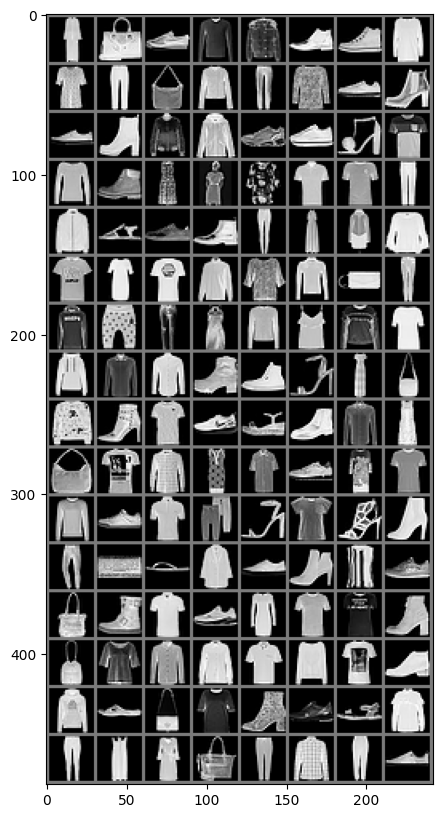

3 8 7 2 4 9 9 2 0 1 8 4 1 6 7 9 7 9 4 4 7 7 5 0 2 9 3 3 6 0 0 1 4 5 7 9 1 3 4 6 0 3 0 2 6 2 8 1 2 1 1 3 2 0 2 0 2 6 6 9 7 5 3 8 2 9 0 7 5 9 6 3 8 0 6 3 6 7 3 0 2 7 0 1 5 0 5 9 1 8 5 4 7 9 0 7 8 9 0 7 3 0 0 9 8 6 6 6 0 2 0 9 2 5 8 0 9 7 5 6 1 3 3 8 1 6 1 7


In [ ]:
def unnormalize(image, mean, std):
    mean = torch.tensor(mean).view(-1, 1, 1)
    print(mean.shape)
    std = torch.tensor(std).view(-1, 1, 1)
    return image * std + mean


def image_show(image):
    image = unnormalize(image, mean, std).numpy()
    image = np.transpose(image, (1, 2, 0))
    fig, axs = plt.subplots(1, 1, figsize=(10, 10))
    axs.imshow(image)
    plt.show()


dataiter = iter(trainloader)
images, labels = next(dataiter)
classes = np.arange(10)

# show images
img_grid = torchvision.utils.make_grid(images)
image_show(img_grid)
# print labels
print(' '.join(f'{classes[labels[j]]}' for j in range(batch_size)))

In [ ]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 16, 5, padding=2)
        self.pool = nn.MaxPool2d(2)
        self.conv2 = nn.Conv2d(16, 32, 5, padding=2)
        self.fc1 = nn.Linear(32 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, 10)


    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = self.fc2(x)

        return x


In [ ]:
import torch.optim as optim

In [ ]:
model = CNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

for epoch in range(5):  # loop over the dataset multiple times
    running_loss = 0.0

    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        if i % 40 == 39:    # every 1000 mini-batches...
            print('Batch {}'.format(i + 1))
            # check against the validation set
            running_vloss = 0.0

            # in evaluation mode some model specific operations can be omitted eg dropout layer
            model.train(False) # switching to evaluation mode, eg turning off regularisation
            for j, vdata in enumerate(testloader, 0):
                vinputs, vlabels = vdata
                voutputs = model(vinputs)
                vloss = criterion(voutputs, vlabels)
                running_vloss += vloss.item()

            model.train(True) # switching back to training mode, eg turning on regularisation
            avg_loss = running_loss / 40
            avg_vloss = running_vloss / len(testloader)
            print("Avg losses", avg_loss, avg_vloss)
            running_loss = 0.0

print('Finished Training')


def accuracy(model, loader):
    model.eval()
    total = 0
    correct = 0
    with torch.no_grad():
        for i, data in enumerate(loader):
            images, labels = data
            ypred = F.softmax(model(images))
            ypred = np.argmax(ypred, axis=1)
            total += labels.size(0)
            correct += (ypred == labels).sum()
    model.train()
    return  correct / total

print("Validation accuracy is: ", accuracy(CNN(), testloader).item())

Batch 40
Avg losses 2.2060285985469816 2.0099938353405724
Batch 80
Avg losses 1.6500395655632019 1.2505719963508317
Batch 120
Avg losses 1.0242188349366188 0.8750505990619901
Batch 160
Avg losses 0.8104569494724274 0.7760002028338516
Batch 200
Avg losses 0.7403688460588456 0.72671480457994
Batch 240
Avg losses 0.6965917676687241 0.7231561666048025
Batch 280
Avg losses 0.6876102849841118 0.6652846815465372
Batch 320
Avg losses 0.6793631106615067 0.6682841819298418
Batch 360
Avg losses 0.6447419315576554 0.6423417401464679
Batch 400
Avg losses 0.6208959765732288 0.6226139559021479
Batch 440
Avg losses 0.6011036686599255 0.5964786953563932
Batch 40
Avg losses 0.5778788395226002 0.6021714350090751
Batch 80
Avg losses 0.5659133262932301 0.6130452439000335
Batch 120
Avg losses 0.5597579702734947 0.580999235940885
Batch 160
Avg losses 0.5521027438342572 0.565298614999916
Batch 200
Avg losses 0.5318639539182186 0.5409351176098932
Batch 240
Avg losses 0.5083706818521023 0.5454329357871527
Batch

<ipython-input-6-ca2213fa0f7c>:51: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  ypred = F.softmax(model(images))


Validation accuracy is:  0.10769999772310257


In [ ]:
def train(model):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

    for epoch in range(5):  # loop over the dataset multiple times
        running_loss = 0.0

        for i, data in enumerate(trainloader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

            if i % 40 == 39:    # Every 1000 mini-batches...
                print('Batch {}'.format(i + 1))
                # Check against the validation set
                running_vloss = 0.0

                model.train(False) # switching to evaluation mode
                for j, vdata in enumerate(testloader, 0):
                    vinputs, vlabels = vdata
                    voutputs = model(vinputs)
                    vloss = criterion(voutputs, vlabels)
                    running_vloss += vloss.item()

                model.train(True) #switching back to training mode
                avg_loss = running_loss / 40
                avg_vloss = running_vloss / len(testloader)
                print("Avg losses", avg_loss, avg_vloss)
                running_loss = 0.0

    print('Finished Training')
    print("Validation accuracy is: ", accuracy(model, testloader).item())

#### Make 2 variations of CNNs (using different convolutions or pooling parameters) and compare them.



In [ ]:
# Variation 1
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 16, 5, padding=2)
        self.pool = nn.MaxPool2d(2)
        self.conv2 = nn.Conv2d(16, 64, 3, padding=2)
        self.fc1 = nn.Linear(4096, 264)
        self.fc2 = nn.Linear(264, 128)
        self.fc3 = nn.Linear(128, 10)
        self.dropout = nn.Dropout(p=0.5)


    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.pool(x)

        x = self.pool(F.relu(self.conv2(x)))

        x = torch.flatten(x, 1)
        x = self.fc1(x)

        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)

        return x

train(CNN())

Batch 40
Avg losses 2.2711119651794434 2.219513250302665
Batch 80
Avg losses 2.1417722165584565 2.047100942346114
Batch 120
Avg losses 1.882041573524475 1.665122195135189
Batch 160
Avg losses 1.4109490364789963 1.1442738499822496
Batch 200
Avg losses 1.0001918196678161 0.8712449028522153
Batch 240
Avg losses 0.8105552330613136 0.7763518178010289
Batch 280
Avg losses 0.7377671092748642 0.7065519181233418
Batch 320
Avg losses 0.6590668231248855 0.6744700862637049
Batch 360
Avg losses 0.6635114215314388 0.6458938898919504
Batch 400
Avg losses 0.6108140669763088 0.6304560669615299
Batch 440
Avg losses 0.6336407460272312 0.6160321601583988
Batch 40
Avg losses 0.579036395996809 0.5869972766200199
Batch 80
Avg losses 0.5774554342031479 0.5795679039592985
Batch 120
Avg losses 0.5722589559853077 0.582933623579484
Batch 160
Avg losses 0.5210979923605918 0.5721240096454379
Batch 200
Avg losses 0.549319252371788 0.5595624443096451
Batch 240
Avg losses 0.5551308564841747 0.5435683783851092
Batch 28

<ipython-input-6-ca2213fa0f7c>:51: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  ypred = F.softmax(model(images))


Validation accuracy is:  0.8562999963760376


In [ ]:
# Variation 2
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 16, 5, padding=2)
        self.pool = nn.MaxPool2d(2)
        self.conv2 = nn.Conv2d(16, 32, 5, padding=2)
        self.fc1 = nn.Linear(32 * 7 * 7, 10)


    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1)
        x = self.fc1(x)

        return x

train(CNN())

Batch 40
Avg losses 2.0180021435022355 1.5428502469123164
Batch 80
Avg losses 1.1582646638154983 0.9027852740468858
Batch 120
Avg losses 0.8222646698355675 0.738068462172641
Batch 160
Avg losses 0.6945968240499496 0.7245611465429957
Batch 200
Avg losses 0.6485430762171746 0.6559668658654901
Batch 240
Avg losses 0.6284217730164527 0.6339861886410774
Batch 280
Avg losses 0.6118763901293278 0.6090374472020548
Batch 320
Avg losses 0.6331334814429284 0.5954385611075389
Batch 360
Avg losses 0.5620986804366112 0.5991828192638445
Batch 400
Avg losses 0.5468122586607933 0.580106332332273
Batch 440
Avg losses 0.5281509719789028 0.5298168021666853
Batch 40
Avg losses 0.5127102822065354 0.5238483612295948
Batch 80
Avg losses 0.5001042850315571 0.5190947153900243
Batch 120
Avg losses 0.4815086081624031 0.5105701262437845
Batch 160
Avg losses 0.487097143381834 0.519811638925649
Batch 200
Avg losses 0.4787208244204521 0.5067046990122976
Batch 240
Avg losses 0.4888055644929409 0.4783104643037048
Batch

<ipython-input-6-ca2213fa0f7c>:51: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  ypred = F.softmax(model(images))


Validation accuracy is:  0.861299991607666


#### Increase the number of Layers of the CNN (the number of convolutions followed by pooling layers) and observe what happens, in terms of the progress of the training and validation losses and the final model accuracies.



In [ ]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 16, 5, padding=2)
        self.pool = nn.MaxPool2d(2)
        self.conv2 = nn.Conv2d(16, 32, 5, padding=2)
        self.conv3 = nn.Conv2d(32, 64, 5, padding=2)
        self.conv4 = nn.Conv2d(64, 128, 5, padding=2)
        self.fc1 = nn.Linear(128, 10)


    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = self.pool(F.relu(self.conv4(x)))
        x = torch.flatten(x, 1)
        x = self.fc1(x)


        return x

train(CNN())


Batch 40
Avg losses 2.294602209329605 2.2828333287299434
Batch 80
Avg losses 2.267328917980194 2.24800540525702
Batch 120
Avg losses 2.2171899378299713 2.1683499209488493
Batch 160
Avg losses 2.073385128378868 1.923867915250078
Batch 200
Avg losses 1.673683586716652 1.37960229191599
Batch 240
Avg losses 1.1747089609503747 1.0325753122945376
Batch 280
Avg losses 0.968928973376751 0.8960574291929414
Batch 320
Avg losses 0.8813301548361778 0.8595517390890967
Batch 360
Avg losses 0.8037544995546341 0.8015009987203381
Batch 400
Avg losses 0.7893470957875252 0.7796977324576317
Batch 440
Avg losses 0.7334077276289463 0.7528188296511203
Batch 40
Avg losses 0.7433347821235656 0.7061084478716307
Batch 80
Avg losses 0.698101595044136 0.7195636256586148
Batch 120
Avg losses 0.6486352115869523 0.7068183090113387
Batch 160
Avg losses 0.6930345982313156 0.6776792361766477
Batch 200
Avg losses 0.6652345702052116 0.6870548479919192
Batch 240
Avg losses 0.6365209206938743 0.6557528365261948
Batch 280
Av

<ipython-input-6-ca2213fa0f7c>:51: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  ypred = F.softmax(model(images))


Validation accuracy is:  0.8226000070571899


#### Visualize some of the Feature Maps and Convolution Kernels

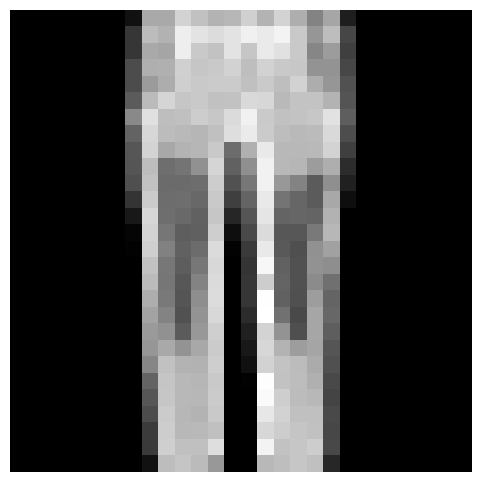

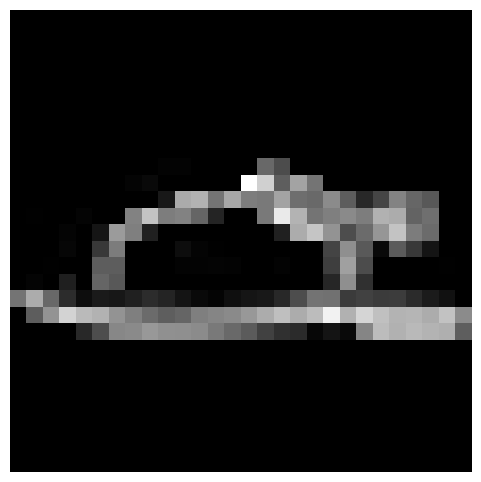

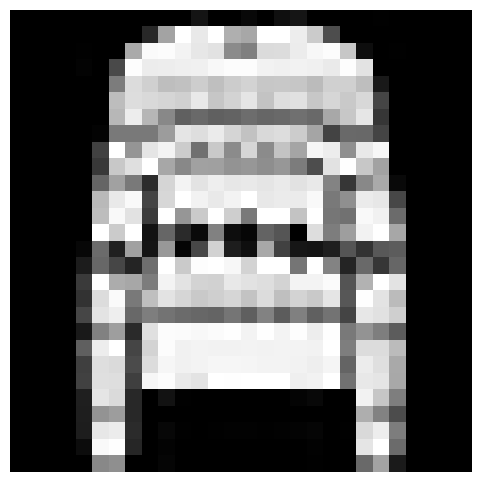

In [ ]:
images = next(iter(trainloader))
L = []
for i in range(3):
    L.append(images[0][i])

for image in L:
    fig, axs = plt.subplots(1, 1, figsize=(6, 6))
    axs.imshow(image.numpy()[0, :, :], cmap="gray")
    axs.axis("off")

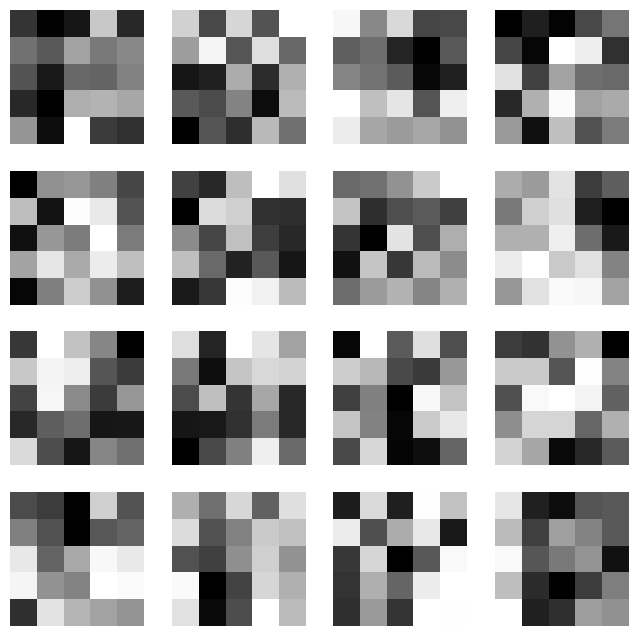

In [ ]:
# Visualizing the kernels


# Extracting the weights of the first convolutional layer
kernels = model.conv1.weight.detach()

# Move kernels to CPU if they are on GPU
kernels = kernels.cpu()

# Normalize kernels to [0,1] for visualization
kernels = (kernels - kernels.min()) / (kernels.max() - kernels.min())

num_kernels = kernels.size(0)

# Set up the subplot dimensions
cols = int(np.sqrt(num_kernels))
rows = (num_kernels // cols) + (0 if num_kernels % cols == 0 else 1)

fig, axs = plt.subplots(rows, cols, figsize=(cols*2, rows*2))

for i, ax in enumerate(axs.flat):
    if i < num_kernels:
        kernel = kernels[i].squeeze()
        ax.imshow(kernel, cmap='gray')
        ax.axis('off')
    else:
        ax.axis('off')

plt.show()